<a href="https://colab.research.google.com/github/yenngocduong/Sign-language-interpreter/blob/main/model_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# filter out word class with less than 16 videos
# filter out frames with all zeros
# randomly select seq_len number of videos

seq_len = 16


## 16 Filter

In [ ]:
class Lang:
    def __init__(self, name):
        self.name = name #language name
        self.word2index = {}    #word to index
        self.word2count = {}    #count of each word
        self.index2word = {} #index to word
        self.n_words = 0 # total number of words
      

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words #get the index of the current word
            self.word2count[word] = 1   #initialise the count of the current word as 1
            self.index2word[self.n_words] = word #update index to word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
path = '/content/drive/MyDrive/EE8101_Deep_Learning/NaN_to_Zero_Arrays'
new_path = '/content/drive/MyDrive/EE8101_Deep_Learning/more_than_16_Arrays'
lst = os.listdir(path)

label_list = []

for a in lst:
  word = a.split('_')[1].split('.')[0]
  label_list.append(word)

In [ ]:
hand_lang_all = Lang('hand')
for w in label_list:
  hand_lang_all.index_word(w)
print(hand_lang_all.word2index)

{'crazy': 0, 'create': 1, 'crocodile': 2, 'cross': 3, 'cry': 4, 'cup': 5, 'curtain': 6, 'cute': 7, 'dance': 8, 'dancer': 9, 'day': 10, 'death': 11, 'decide': 12, 'deep': 13, 'deer': 14, 'delicious': 15, 'demand': 16, 'dentist': 17, 'deny': 18, 'deodorant': 19, 'department': 20, 'desert': 21, 'devil': 22, 'diamond': 23, 'diaper': 24, 'dice': 25, 'dinosaur': 26, 'die': 27, 'dirty': 28, 'disappear': 29, 'dive': 30, 'divorce': 31, 'dog': 32, 'doctor': 33, 'doll': 34, 'dolphin': 35, 'door': 36, 'dormitory': 37, 'doubt': 38, 'draw': 39, 'drawer': 40, 'dream': 41, 'dress': 42, 'drink': 43, 'drop': 44, 'drum': 45, 'drunk': 46, 'duck': 47, 'eagle': 48, 'dumb': 49, 'ear': 50, 'earn': 51, 'earring': 52, 'earth': 53, 'east': 54, 'earthquake': 55, 'easy': 56, 'eat': 57, 'egg': 58, 'egypt': 59, 'electrician': 60, 'elephant': 61, 'email': 62, 'embarrass': 63, 'emotion': 64, 'engagement': 65, 'engineer': 66, 'enjoy': 67, 'english': 68, 'enough': 69, 'envelope': 70, 'equal': 71, 'eraser': 72, 'evaluate

In [ ]:
words_remaining = []
for key, value in hand_lang_all.word2count.items():
  if value >= 16:
    words_remaining.append(key)
len(words_remaining), words_remaining

(18,
 ['drink',
  'fine',
  'go',
  'help',
  'many',
  'mother',
  'no',
  'orange',
  'before',
  'candy',
  'computer',
  'deaf',
  'who',
  'yes',
  'cool',
  'hot',
  'cousin',
  'thin'])

In [ ]:
#update label_list and save the filtered arrays 

label_list = []
for a in tqdm(lst):
  word = a.split('_')[1].split('.')[0]
  if word in words_remaining:
    label_list.append(word)
    m = np.load(path + '/' + a)
    save_path = new_path + '/' + a
    np.save(save_path, m)

100%|██████████| 17875/17875 [00:03<00:00, 4561.56it/s]


In [ ]:
lst = os.listdir(new_path)
len(lst)

398

# zero Filter

In [ ]:
import os
import numpy as np
from tqdm import tqdm

# path = '/content/drive/MyDrive/EE8101_Deep_Learning/more_than_16_Arrays'
path = '/content/drive/MyDrive/EE8101_Deep_Learning/NaN_to_Zero_Arrays'
new_path = '/content/drive/MyDrive/EE8101_Deep_Learning/NaN_to_Zero_without0_Arrays'

lst = os.listdir(path)

before_len = []
after_len = []

for a in tqdm(lst):
  m = np.load(path + '/' + a)

  index = []
  for i in range(m.shape[0]):
    if m[i][0][0][0] == 0:
      index.append(i)

  m_del = np.delete(m, index, 0)
  save_path = new_path + '/' + a
  np.save(save_path, m_del)

  b_len = m.shape[0]
  af_len = m_del.shape[0]
  before_len.append(b_len)
  after_len.append(af_len)


100%|██████████| 17875/17875 [1:53:29<00:00,  2.63it/s]


In [ ]:
b_lens = np.array(before_len)
af_lens = np.array(after_len)
b_lens.mean(), af_lens.mean()

(67.66834170854271, 42.3391959798995)

# seq len Filter

In [ ]:
## this sampling part may be done in Dataset

import random

def seq_len_filter(m, seq_len):
  b_len = m.shape[0]
  lucky_index = []
  for i in range(seq_len):
    lucky_index.append(random.randint(0, b_len-1))
  lucky_index.sort()

  new_m = m[lucky_index]
  return new_m


In [ ]:
path = '/content/drive/MyDrive/EE8101_Deep_Learning/more_than_16_without0_Arrays'
new_path = path + '_' + str(seq_len)

lst = os.listdir(path)

for a in tqdm(lst):
  m = np.load(path + '/' + a)
  if m.shape[0] <= 10:  # neglect arrays with less than 10 frames
    continue
  new_m = seq_len_filter(m, seq_len)
  save_path = new_path + '/' + a
  np.save(save_path, new_m)

100%|██████████| 1989/1989 [00:17<00:00, 115.79it/s]


In [ ]:
len(os.listdir(new_path))

1960

# dataset & dataloader

In [ ]:
path = '/content/drive/MyDrive/EE8101_Deep_Learning/more_than_16_without0_Arrays'
path = path + '_' + str(seq_len)
lst = os.listdir(path)

label_list = []
array_list = []

for a in tqdm(lst):
  m = np.load(path + '/' + a)
  word = a.split('_')[1].split('.')[0]
  label_list.append(word)
  array_list.append(m)

hand_lang = Lang('hand')
for w in label_list:
  hand_lang.index_word(w)
print(hand_lang.word2index)
print(hand_lang.word2count)

100%|██████████| 1960/1960 [00:03<00:00, 642.26it/s]

{'cry': 0, 'dance': 1, 'decide': 2, 'dog': 3, 'doctor': 4, 'door': 5, 'drink': 6, 'eat': 7, 'enjoy': 8, 'family': 9, 'fine': 10, 'finish': 11, 'fish': 12, 'full': 13, 'go': 14, 'graduate': 15, 'hat': 16, 'hearing': 17, 'help': 18, 'how': 19, 'kiss': 20, 'last': 21, 'language': 22, 'later': 23, 'laugh': 24, 'learn': 25, 'letter': 26, 'man': 27, 'many': 28, 'meet': 29, 'mother': 30, 'need': 31, 'no': 32, 'now': 33, 'orange': 34, 'paint': 35, 'paper': 36, 'pink': 37, 'all': 38, 'apple': 39, 'before': 40, 'blue': 41, 'book': 42, 'but': 43, 'candy': 44, 'color': 45, 'computer': 46, 'cook': 47, 'deaf': 48, 'forget': 49, 'like': 50, 'play': 51, 'purple': 52, 'right': 53, 'study': 54, 'teacher': 55, 'walk': 56, 'want': 57, 'water': 58, 'white': 59, 'who': 60, 'woman': 61, 'wrong': 62, 'year': 63, 'yellow': 64, 'yes': 65, 'basketball': 66, 'bird': 67, 'black': 68, 'brown': 69, 'can': 70, 'cat': 71, 'city': 72, 'cool': 73, 'corn': 74, 'cow': 75, 'dark': 76, 'give': 77, 'hot': 78, 'pizza': 79, 'p

In [ ]:
y = []
for w in label_list:
  i = hand_lang.word2index[w]
  y.append(i)
print(y)

[0, 1, 2, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 42, 43, 44, 45, 46, 47, 1, 48, 3, 5, 6, 6, 7, 8, 10, 11, 49, 49, 16, 17, 22, 22, 21, 25, 26, 50, 29, 32, 33, 34, 35, 36, 37, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 38, 39, 66, 67, 68, 41, 42, 69, 70, 71, 72, 45, 73, 74, 75, 76, 3, 6, 7, 9, 12, 77, 14, 16, 18, 78, 19, 50, 27, 28, 30, 32, 33, 34, 37, 79, 51, 80, 52, 81, 57, 82, 59, 60, 83, 64, 65, 48, 84, 13, 47, 4, 8, 58, 67, 2, 62, 1, 6, 25, 36, 85, 86, 31, 69, 37, 52, 34, 83, 5, 42, 78, 73, 19, 62, 50, 63, 28, 39, 34, 26, 44, 87, 88, 89, 40, 90, 11, 49, 91, 14, 15, 17, 18, 18, 18, 92, 20, 22, 22, 21, 23, 23, 24, 25, 26, 27, 27, 27, 29, 30, 30, 32, 34, 37, 79, 80, 52, 93, 93, 94, 90, 86, 81, 81, 88, 88, 54, 95, 95, 55, 96, 96, 84, 84, 84, 84, 97, 98, 56, 56, 58, 82, 60, 60, 85, 99, 99, 61, 61, 100, 83, 63, 63, 64, 65, 89, 89, 100, 83, 62, 62, 63

In [ ]:
X = np.array(array_list)
y = np.array(y)
X.shape, y.shape

((1960, 16, 2, 21, 3), (1960,))

In [ ]:
X = X.reshape((X.shape[0], seq_len, -1))
X.shape

(1960, 16, 126)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 2021)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size = 0.15, random_state = 2021)

In [ ]:
from torch.utils.data import Dataset, DataLoader

train_dataset = [(X_train[i], y_train[i]) for i in range(len(X_train))]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dev_dataset = [(X_dev[i], y_dev[i]) for i in range(len(X_dev))]
dev_loader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False)

test_dataset = [(X_test[i], y_test[i]) for i in range(len(X_test))]
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

# Model

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper-parameters
input_size = 2 * 21 * 3
hidden_size = 128
num_layers = 2
# nonlinearity = 'tanh'
num_epochs = 50
batch_size = 16
learning_rate = 0.001

In [ ]:
num_classes = y.max() + 1
num_classes

111

In [ ]:
def topk_correct(outputs, labels, topk):
  correct = 0
  outputs = outputs.topk(topk, dim = -1).indices
  for i, label in enumerate(labels):
    # print(outputs[i])
    if label in outputs[i]:
      
      correct += 1
  return correct


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.foc = nn.Linear((hidden_size), (num_classes))

    def forward(self, x):
        x, h_n = self.gru(x)
        output = self.foc(h_n[-1])
        return output

In [ ]:
model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
losses = []
train_accs = []
dev_accs = []
dev_accs_top3 = []
dev_accs_top10 = []

print_loss_every_step = 20

for epoch in range(num_epochs):

    for i, (arrays, labels) in enumerate(train_loader):
        
        labels = labels.to(torch.long).to(device)

        # Forward pass
        outputs = model(arrays)
        loss = criterion(outputs, labels)
        losses.append(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % print_loss_every_step == 0:
          print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
    
    with torch.no_grad():
        total = 0
        total_correct = 0
        for i, (arrays, labels) in enumerate(train_loader):
            labels = labels.to(torch.long).to(device)
            # Forward pass
            outputs = model(arrays)
            outputs = torch.argmax(outputs, dim=-1)

            # Backward and optimize
            total += len(outputs)
            total_correct += (outputs == labels).sum().item()

        train_acc = total_correct / total
        train_accs.append(train_acc)

        print(f"train Accuracy: {total_correct / total * 100:.2f}")

    with torch.no_grad():
        total = 0
        total_correct = 0
        total_top3_correct = 0
        total_top10_correct = 0
        for i, (arrays, labels) in enumerate(dev_loader):
            labels = labels.to(torch.long).to(device)
            # Forward pass
            outputs = model(arrays)
            preds = torch.argmax(outputs, dim=-1)

            # Backward and optimize
            total += len(preds)
            total_correct += (preds == labels).sum().item()
            total_top3_correct += topk_correct(outputs, labels, 3)
            total_top10_correct += topk_correct(outputs, labels, 10)


        dev_acc = total_correct / total
        dev_accs.append(dev_acc)
        dev_accs_top3.append(total_top3_correct / total)
        dev_accs_top10.append(total_top10_correct / total)

        print(f"dev Accuracy: {total_correct / total * 100:.2f}")
        print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
        print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

Epoch [1/50], Step [20], Loss: 4.6980
Epoch [1/50], Step [40], Loss: 4.6767
Epoch [1/50], Step [60], Loss: 4.5067
Epoch [1/50], Step [80], Loss: 4.5776
train Accuracy: 2.54
dev Accuracy: 0.38
dev top 3 Accuracy: 3.02
dev top 10 Accuracy: 13.58
Epoch [2/50], Step [20], Loss: 4.2952
Epoch [2/50], Step [40], Loss: 4.5567
Epoch [2/50], Step [60], Loss: 4.4185
Epoch [2/50], Step [80], Loss: 4.2726
train Accuracy: 5.94
dev Accuracy: 1.51
dev top 3 Accuracy: 6.04
dev top 10 Accuracy: 25.66
Epoch [3/50], Step [20], Loss: 4.1072
Epoch [3/50], Step [40], Loss: 4.3538
Epoch [3/50], Step [60], Loss: 4.4551
Epoch [3/50], Step [80], Loss: 4.0173
train Accuracy: 6.34
dev Accuracy: 1.89
dev top 3 Accuracy: 10.57
dev top 10 Accuracy: 33.21
Epoch [4/50], Step [20], Loss: 4.0580
Epoch [4/50], Step [40], Loss: 4.1548
Epoch [4/50], Step [60], Loss: 3.7958
Epoch [4/50], Step [80], Loss: 3.9526
train Accuracy: 8.01
dev Accuracy: 4.15
dev top 3 Accuracy: 12.83
dev top 10 Accuracy: 33.96
Epoch [5/50], Step [20

Text(0.5, 1.0, 'train loss')

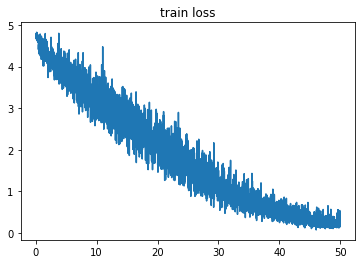

In [ ]:
import matplotlib.pyplot as plt

a = np.arange(len(losses))
a = a / len(train_loader)

plt.plot(a, losses)
plt.title('train loss')

Text(0.5, 1.0, 'train and dev accuracy')

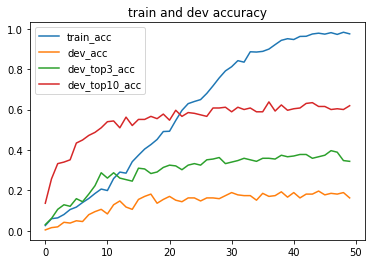

In [ ]:
plt.plot(train_accs, label = 'train_acc')
plt.plot(dev_accs, label = 'dev_acc')
plt.plot(dev_accs_top3, label = 'dev_top3_acc')
plt.plot(dev_accs_top10, label = 'dev_top10_acc')
plt.legend()
plt.title('train and dev accuracy')

In [ ]:
model_path = '/content/drive/MyDrive/EE8101_Deep_Learning/Model_try/' + 'yujing_model1_seq16.pt'
torch.save(model.state_dict(), model_path)

# new dataset & dataloader

In [ ]:
path = '/content/drive/MyDrive/EE8101_Deep_Learning/more_than_16_without0_Arrays'

lst = os.listdir(path)

label_list = []
array_list = []

for a in tqdm(lst):
  m = np.load(path + '/' + a)
  if m.shape[0] <= 10:  # neglect arrays with less than 10 frames
    continue
  word = a.split('_')[1].split('.')[0]
  label_list.append(word)
  array_list.append(m)

hand_lang = Lang('hand')
for w in label_list:
  hand_lang.index_word(w)
print(hand_lang.word2index)
print(hand_lang.word2count)

y = []
for w in label_list:
  i = hand_lang.word2index[w]
  y.append(i)

y = np.array(y)

100%|██████████| 1989/1989 [00:03<00:00, 576.88it/s]

{'cry': 0, 'dance': 1, 'decide': 2, 'dog': 3, 'doctor': 4, 'door': 5, 'drink': 6, 'eat': 7, 'enjoy': 8, 'family': 9, 'fine': 10, 'finish': 11, 'fish': 12, 'full': 13, 'go': 14, 'graduate': 15, 'hat': 16, 'hearing': 17, 'help': 18, 'how': 19, 'kiss': 20, 'last': 21, 'language': 22, 'later': 23, 'laugh': 24, 'learn': 25, 'letter': 26, 'man': 27, 'many': 28, 'meet': 29, 'mother': 30, 'need': 31, 'no': 32, 'now': 33, 'orange': 34, 'paint': 35, 'paper': 36, 'pink': 37, 'all': 38, 'apple': 39, 'before': 40, 'blue': 41, 'book': 42, 'but': 43, 'candy': 44, 'color': 45, 'computer': 46, 'cook': 47, 'deaf': 48, 'forget': 49, 'like': 50, 'play': 51, 'purple': 52, 'right': 53, 'study': 54, 'teacher': 55, 'walk': 56, 'want': 57, 'water': 58, 'white': 59, 'who': 60, 'woman': 61, 'wrong': 62, 'year': 63, 'yellow': 64, 'yes': 65, 'basketball': 66, 'bird': 67, 'black': 68, 'brown': 69, 'can': 70, 'cat': 71, 'city': 72, 'cool': 73, 'corn': 74, 'cow': 75, 'dark': 76, 'give': 77, 'hot': 78, 'pizza': 79, 'p

In [ ]:
from sklearn.model_selection import train_test_split
list_train, list_test, y_train, y_test =  train_test_split(array_list, y, test_size = 0.1, random_state = 2021)
list_train, list_dev, y_train, y_dev = train_test_split(list_train, y_train, test_size = 0.15, random_state = 2021)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import random

def seq_len_filter(m, seq_len):
  b_len = m.shape[0]
  lucky_index = []
  for i in range(seq_len):
    lucky_index.append(random.randint(0, b_len-1))
  lucky_index.sort()

  new_m = m[lucky_index]
  new_m = new_m.reshape((seq_len, -1))
  return new_m

class Seq_len_dataset(Dataset):
  def __init__(self, list_of_arrays, y, seq_len):
    self.list_of_arrays = list_of_arrays
    self.y = y
    self.seq_len = seq_len

  def __len__(self):
    return len(self.list_of_arrays)
  
  def __getitem__(self, idx):
    array = self.list_of_arrays[idx]
    array = seq_len_filter(array, seq_len)
    label = self.y[idx]
    return (array, label)
 
train_dataset = Seq_len_dataset(list_train, y_train, seq_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataset = Seq_len_dataset(list_dev, y_dev, seq_len)
dev_loader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False)
test_dataset = Seq_len_dataset(list_test, y_test, seq_len)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
print(len(train_loader))

94


In [ ]:
print(len(train_dataset))

1499


In [ ]:
train_dataset[1][0].shape

(16, 126)

# Old Model new train

In [ ]:
num_classes = y.max() + 1
num_classes

111

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper-parameters
input_size = 2 * 21 * 3
hidden_size = 128
num_layers = 2
# nonlinearity = 'tanh'
num_epochs = 100
batch_size = 16
learning_rate = 0.001

In [ ]:
def topk_correct(outputs, labels, topk):
  correct = 0
  outputs = outputs.topk(topk, dim = -1).indices
  for i, label in enumerate(labels):
    # print(outputs[i])
    if label in outputs[i]:
      
      correct += 1
  return correct

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.foc = nn.Linear((hidden_size), (num_classes))

    def forward(self, x):
        x, h_n = self.gru(x)
        output = self.foc(h_n[-1])
        return output

In [ ]:
model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
losses = []
train_accs = []
dev_accs = []
dev_accs_top3 = []
dev_accs_top10 = []

print_loss_every_step = 20

num_epochs = 100
for epoch in range(num_epochs):

    for i, (arrays, labels) in enumerate(train_loader):
        
        labels = labels.to(torch.long).to(device)

        # Forward pass
        outputs = model(arrays)
        loss = criterion(outputs, labels)
        losses.append(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % print_loss_every_step == 0:
          print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
    
    with torch.no_grad():
        total = 0
        total_correct = 0
        for i, (arrays, labels) in enumerate(train_loader):
            labels = labels.to(torch.long).to(device)
            # Forward pass
            outputs = model(arrays)
            outputs = torch.argmax(outputs, dim=-1)

            # Backward and optimize
            total += len(outputs)
            total_correct += (outputs == labels).sum().item()

        train_acc = total_correct / total
        train_accs.append(train_acc)

        print(f"train Accuracy: {total_correct / total * 100:.2f}")

    with torch.no_grad():
        total = 0
        total_correct = 0
        total_top3_correct = 0
        total_top10_correct = 0
        for i, (arrays, labels) in enumerate(dev_loader):
            labels = labels.to(torch.long).to(device)
            # Forward pass
            outputs = model(arrays)
            preds = torch.argmax(outputs, dim=-1)

            # Backward and optimize
            total += len(preds)
            total_correct += (preds == labels).sum().item()
            total_top3_correct += topk_correct(outputs, labels, 3)
            total_top10_correct += topk_correct(outputs, labels, 10)


        dev_acc = total_correct / total
        dev_accs.append(dev_acc)
        dev_accs_top3.append(total_top3_correct / total)
        dev_accs_top10.append(total_top10_correct / total)

        print(f"dev Accuracy: {total_correct / total * 100:.2f}")
        print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
        print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

Epoch [1/100], Step [20], Loss: 4.6812
Epoch [1/100], Step [40], Loss: 4.6374
Epoch [1/100], Step [60], Loss: 4.2286
Epoch [1/100], Step [80], Loss: 4.6373
train Accuracy: 2.67
dev Accuracy: 2.26
dev top 3 Accuracy: 3.77
dev top 10 Accuracy: 14.72
Epoch [2/100], Step [20], Loss: 4.5104
Epoch [2/100], Step [40], Loss: 4.4586
Epoch [2/100], Step [60], Loss: 4.1646
Epoch [2/100], Step [80], Loss: 4.2890
train Accuracy: 4.74
dev Accuracy: 3.77
dev top 3 Accuracy: 9.43
dev top 10 Accuracy: 27.55
Epoch [3/100], Step [20], Loss: 3.7855
Epoch [3/100], Step [40], Loss: 4.2441
Epoch [3/100], Step [60], Loss: 4.2126
Epoch [3/100], Step [80], Loss: 4.2309
train Accuracy: 7.54
dev Accuracy: 3.40
dev top 3 Accuracy: 9.81
dev top 10 Accuracy: 31.70
Epoch [4/100], Step [20], Loss: 3.9341
Epoch [4/100], Step [40], Loss: 3.8129
Epoch [4/100], Step [60], Loss: 3.6665
Epoch [4/100], Step [80], Loss: 4.1982
train Accuracy: 6.67
dev Accuracy: 4.53
dev top 3 Accuracy: 9.81
dev top 10 Accuracy: 35.09
Epoch [5

Text(0.5, 1.0, 'train loss')

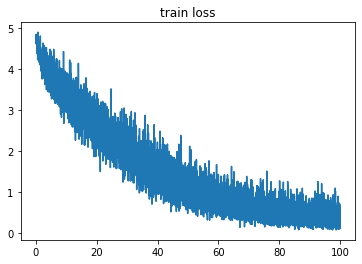

In [ ]:
import matplotlib.pyplot as plt

a = np.arange(len(losses))
a = a / len(train_loader)

plt.plot(a, losses)
plt.title('train loss')

Text(0.5, 1.0, 'train and dev accuracy')

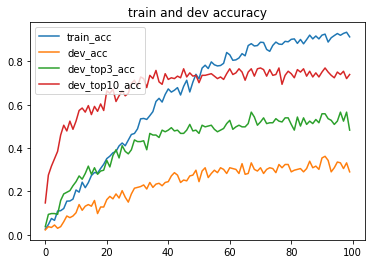

In [ ]:
plt.plot(train_accs, label = 'train_acc')
plt.plot(dev_accs, label = 'dev_acc')
plt.plot(dev_accs_top3, label = 'dev_top3_acc')
plt.plot(dev_accs_top10, label = 'dev_top10_acc')
plt.legend()
plt.title('train and dev accuracy')

In [ ]:
model_path = '/content/drive/MyDrive/EE8101_Deep_Learning/Model_try/' + 'yujing_model2_seq16.pt'
torch.save(model.state_dict(), model_path)

# HP: seq_len

In [ ]:
seq_lens = [2, 4, 8, 16, 32, 64]

input_size = 2 * 21 * 3
hidden_size = 128
num_layers = 2
num_epochs = 50
batch_size = 16
learning_rate = 0.001

In [ ]:
train_accs_list = []
dev_accs_list = []
dev_accs_top3_list = []
dev_accs_top10_list = []

for seq_len in seq_lens:
  print(seq_len)
  train_dataset = Seq_len_dataset(list_train, y_train, seq_len)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  dev_dataset = Seq_len_dataset(list_dev, y_dev, seq_len)
  dev_loader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = False)

  model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  # losses = []
  train_accs = []
  dev_accs = []
  dev_accs_top3 = []
  dev_accs_top10 = []

  print_loss_every_step = 20

  for epoch in range(num_epochs):
      print('seq_len ', str(seq_len), 'epoch ', str(epoch + 1), '/50')

      for i, (arrays, labels) in enumerate(train_loader):
          
          labels = labels.to(torch.long).to(device)

          # Forward pass
          outputs = model(arrays)
          loss = criterion(outputs, labels)
          # losses.append(loss)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # if (i+1) % print_loss_every_step == 0:
            # print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
      
      with torch.no_grad():
          total = 0
          total_correct = 0
          for i, (arrays, labels) in enumerate(train_loader):
              labels = labels.to(torch.long).to(device)
              # Forward pass
              outputs = model(arrays)
              outputs = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(outputs)
              total_correct += (outputs == labels).sum().item()

          train_acc = total_correct / total
          train_accs.append(train_acc)

          print(f"train Accuracy: {total_correct / total * 100:.2f}")

      with torch.no_grad():
          total = 0
          total_correct = 0
          total_top3_correct = 0
          total_top10_correct = 0
          for i, (arrays, labels) in enumerate(dev_loader):
              labels = labels.to(torch.long).to(device)
              # Forward pass
              outputs = model(arrays)
              preds = torch.argmax(outputs, dim=-1)

              # Backward and optimize
              total += len(preds)
              total_correct += (preds == labels).sum().item()
              total_top3_correct += topk_correct(outputs, labels, 3)
              total_top10_correct += topk_correct(outputs, labels, 10)


          dev_acc = total_correct / total
          dev_accs.append(dev_acc)
          dev_accs_top3.append(total_top3_correct / total)
          dev_accs_top10.append(total_top10_correct / total)

          print(f"dev Accuracy: {total_correct / total * 100:.2f}")
          print(f"dev top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
          print(f"dev top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

  train_accs_list.append(train_accs)
  dev_accs_list.append(dev_accs)
  dev_accs_top3_list.append(dev_accs_top3)
  dev_accs_top10_list.append(dev_accs_top10)


2
seq_len  2 epoch  1 /50
train Accuracy: 2.80
dev Accuracy: 1.13
dev top 3 Accuracy: 4.91
dev top 10 Accuracy: 14.34
seq_len  2 epoch  2 /50
train Accuracy: 3.67
dev Accuracy: 1.51
dev top 3 Accuracy: 4.15
dev top 10 Accuracy: 17.36
seq_len  2 epoch  3 /50
train Accuracy: 4.14
dev Accuracy: 1.89
dev top 3 Accuracy: 8.30
dev top 10 Accuracy: 23.02
seq_len  2 epoch  4 /50
train Accuracy: 4.40
dev Accuracy: 1.89
dev top 3 Accuracy: 6.04
dev top 10 Accuracy: 21.13
seq_len  2 epoch  5 /50
train Accuracy: 4.74
dev Accuracy: 3.40
dev top 3 Accuracy: 10.19
dev top 10 Accuracy: 29.43
seq_len  2 epoch  6 /50
train Accuracy: 5.80
dev Accuracy: 4.53
dev top 3 Accuracy: 10.94
dev top 10 Accuracy: 33.96
seq_len  2 epoch  7 /50
train Accuracy: 7.07
dev Accuracy: 4.15
dev top 3 Accuracy: 12.08
dev top 10 Accuracy: 35.09
seq_len  2 epoch  8 /50
train Accuracy: 8.14
dev Accuracy: 6.42
dev top 3 Accuracy: 15.85
dev top 10 Accuracy: 37.36
seq_len  2 epoch  9 /50
train Accuracy: 8.41
dev Accuracy: 5.28
de

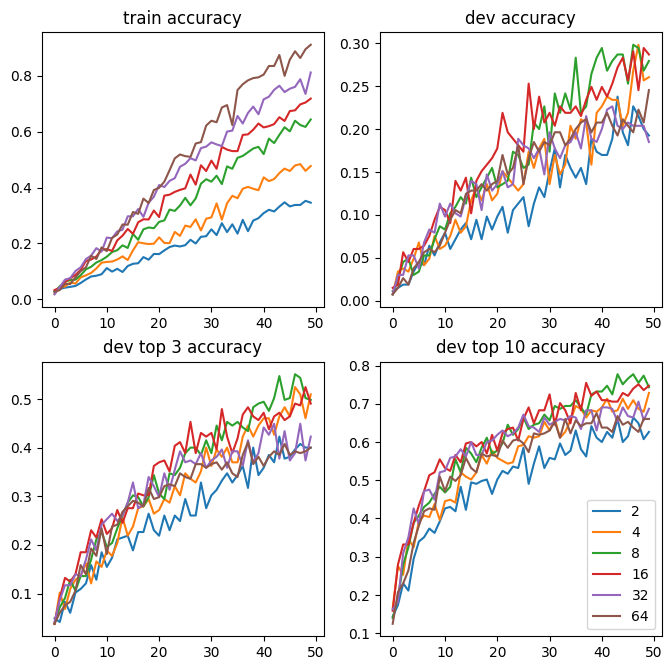

In [ ]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(2, 2, figsize = (8, 8), dpi = 100)
ax = axes.flatten()



for i, seq_len in enumerate(seq_lens):
  ax[0].plot(train_accs_list[i], label = str(seq_len))
  ax[1].plot(dev_accs_list[i], label = str(seq_len))
  ax[2].plot(dev_accs_top3_list[i], label = str(seq_len))
  ax[3].plot(dev_accs_top10_list[i], label = str(seq_len))
  


ax[0].set_title('train accuracy')
ax[1].set_title('dev accuracy')
ax[2].set_title('dev top 3 accuracy')
ax[3].set_title('dev top 10 accuracy')
plt.legend()


# Save dataset to download

In [ ]:
import pickle

my_data = [list_train, list_dev, list_test, y_train, y_dev, y_test]
data_path = '/content/drive/MyDrive/EE8101_Deep_Learning/datasets.pkl'
data_output = open(data_path, 'wb')
pickle.dump(my_data, data_output)
data_output.close()

In [ ]:
data_input = open(data_path, 'rb')
read_data = pickle.load(data_input)
data_input.close()

a = read_data[0][0]
a.shape

(28, 2, 21, 3)

In [ ]:
my_data = [label_list, array_list]
data_path = '/content/drive/MyDrive/EE8101_Deep_Learning/dataset.pkl'
data_output = open(data_path, 'wb')
pickle.dump(my_data, data_output)
data_output.close()

In [ ]:
type([1, 2, 3]) is list

True

# Model for demostration (somehow not improved)

In [ ]:
path = '/content/drive/MyDrive/EE8101_Deep_Learning/more_than_20_without0_Arrays'

lst = os.listdir(path)

label_list = []
array_list = []

for a in tqdm(lst):
  m = np.load(path + '/' + a)
  if m.shape[0] <= 10:  # neglect arrays with less than 10 frames
    continue
  word = a.split('_')[1].split('.')[0]
  label_list.append(word)
  array_list.append(m)

hand_lang = Lang('hand')
for w in label_list:
  hand_lang.index_word(w)
print(hand_lang.word2index)
print(hand_lang.word2count)

y = []
for w in label_list:
  i = hand_lang.word2index[w]
  y.append(i)

y = np.array(y)

100%|██████████| 398/398 [00:00<00:00, 610.89it/s]

{'drink': 0, 'fine': 1, 'go': 2, 'help': 3, 'many': 4, 'mother': 5, 'no': 6, 'orange': 7, 'before': 8, 'candy': 9, 'computer': 10, 'deaf': 11, 'who': 12, 'yes': 13, 'cool': 14, 'hot': 15, 'cousin': 16, 'thin': 17}
{'drink': 32, 'fine': 19, 'go': 23, 'help': 21, 'many': 20, 'mother': 20, 'no': 20, 'orange': 18, 'before': 24, 'candy': 22, 'computer': 28, 'deaf': 21, 'who': 22, 'yes': 20, 'cool': 21, 'hot': 20, 'cousin': 20, 'thin': 21}


In [ ]:
# my_data = [label_list, array_list]
# data_path = '/content/drive/MyDrive/EE8101_Deep_Learning/dataset_for_demo.pkl'
# data_output = open(data_path, 'wb')
# pickle.dump(my_data, data_output)
# data_output.close()

In [ ]:
from sklearn.model_selection import train_test_split
list_train, list_test, y_train, y_test =  train_test_split(array_list, y, test_size = 0.1, random_state = 2021)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import random

def seq_len_filter(m, seq_len):
  b_len = m.shape[0]
  lucky_index = []
  for i in range(seq_len):
    lucky_index.append(random.randint(0, b_len-1))
  lucky_index.sort()

  new_m = m[lucky_index]
  new_m = new_m.reshape((seq_len, -1))
  return new_m

class Seq_len_dataset(Dataset):
  def __init__(self, list_of_arrays, y, seq_len):
    self.list_of_arrays = list_of_arrays
    self.y = y
    self.seq_len = seq_len

  def __len__(self):
    return len(self.list_of_arrays)
  
  def __getitem__(self, idx):
    array = self.list_of_arrays[idx]
    array = seq_len_filter(array, seq_len)
    label = self.y[idx]
    return (array, label)
 
train_dataset = Seq_len_dataset(list_train, y_train, seq_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = Seq_len_dataset(list_test, y_test, seq_len)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper-parameters
input_size = 2 * 21 * 3
hidden_size = 256
num_layers = 2
# nonlinearity = 'tanh'
num_epochs = 100
batch_size = 16
learning_rate = 0.001
num_classes = y.max() + 1
num_classes

18

In [ ]:
model = RNN(input_size, hidden_size, num_layers, num_classes).double().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-4 )

losses = []
train_accs = []
test_accs = []
test_accs_top3 = []
test_accs_top10 = []
print_loss_every_step = 20

num_epochs = 50
for epoch in range(num_epochs):

    for i, (arrays, labels) in enumerate(train_loader):
        
        labels = labels.to(torch.long).to(device)

        # Forward pass
        outputs = model(arrays)
        loss = criterion(outputs, labels)
        losses.append(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % print_loss_every_step == 0:
          print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')
    
    with torch.no_grad():
        total = 0
        total_correct = 0
        for i, (arrays, labels) in enumerate(train_loader):
            labels = labels.to(torch.long).to(device)
            # Forward pass
            outputs = model(arrays)
            outputs = torch.argmax(outputs, dim=-1)

            # Backward and optimize
            total += len(outputs)
            total_correct += (outputs == labels).sum().item()

        train_acc = total_correct / total
        train_accs.append(train_acc)

        print(f"train Accuracy: {total_correct / total * 100:.2f}")

    with torch.no_grad(): 
        total = 0
        total_correct = 0
        total_top3_correct = 0
        total_top10_correct = 0
        for i, (arrays, labels) in enumerate(test_loader):
            labels = labels.to(torch.long).to(device)
            # Forward pass
            outputs = model(arrays)
            preds = torch.argmax(outputs, dim=-1)

            # Backward and optimize
            total += len(preds)
            total_correct += (preds == labels).sum().item()
            total_top3_correct += topk_correct(outputs, labels, 3)
            total_top10_correct += topk_correct(outputs, labels, 10)


        test_acc = total_correct / total
        test_accs.append(test_acc)
        test_accs_top3.append(total_top3_correct / total)
        test_accs_top10.append(total_top10_correct / total)

        print(f"test Accuracy: {total_correct / total * 100:.2f}")
        print(f"test top 3 Accuracy: {total_top3_correct / total * 100:.2f}")
        print(f"test top 10 Accuracy: {total_top10_correct / total * 100:.2f}")

Epoch [1/50], Step [20], Loss: 2.7719
train Accuracy: 10.51
test Accuracy: 2.50
test top 3 Accuracy: 25.00
test top 10 Accuracy: 75.00
Epoch [2/50], Step [20], Loss: 2.6207
train Accuracy: 15.91
test Accuracy: 15.00
test top 3 Accuracy: 30.00
test top 10 Accuracy: 70.00
Epoch [3/50], Step [20], Loss: 2.6602
train Accuracy: 18.47
test Accuracy: 20.00
test top 3 Accuracy: 40.00
test top 10 Accuracy: 85.00
Epoch [4/50], Step [20], Loss: 2.5410
train Accuracy: 21.02
test Accuracy: 15.00
test top 3 Accuracy: 32.50
test top 10 Accuracy: 87.50
Epoch [5/50], Step [20], Loss: 2.1298
train Accuracy: 20.17
test Accuracy: 15.00
test top 3 Accuracy: 37.50
test top 10 Accuracy: 82.50
Epoch [6/50], Step [20], Loss: 2.2909
train Accuracy: 26.99
test Accuracy: 20.00
test top 3 Accuracy: 35.00
test top 10 Accuracy: 85.00
Epoch [7/50], Step [20], Loss: 2.4425
train Accuracy: 31.25
test Accuracy: 17.50
test top 3 Accuracy: 37.50
test top 10 Accuracy: 87.50
Epoch [8/50], Step [20], Loss: 2.5113
train Accur

Text(0.5, 1.0, 'train loss')

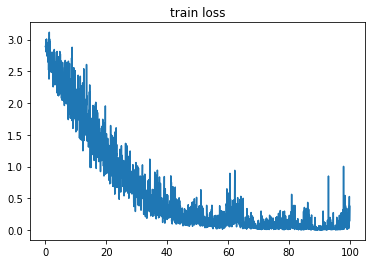

In [ ]:
import matplotlib.pyplot as plt

a = np.arange(len(losses))
a = a / len(train_loader)

plt.plot(a, losses)
plt.title('train loss')

Text(0.5, 1.0, 'train and test accuracy')

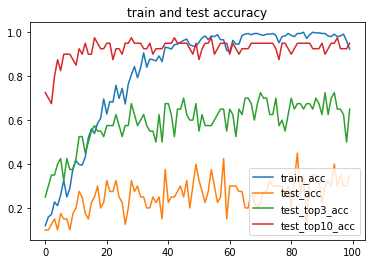

In [ ]:
plt.plot(train_accs, label = 'train_acc')
plt.plot(test_accs, label = 'test_acc')
plt.plot(test_accs_top3, label = 'test_top3_acc')
plt.plot(test_accs_top10, label = 'test_top10_acc')
plt.legend()
plt.title('train and test accuracy')